## Docker specific configurations

Prepare python path

In [1]:
from sys import path
from pathlib import Path
path.append(str(Path("../../").resolve()))

## Prepare mesh

Generate mesh outside of the docker using the following commands:
```bash
gmsh mesh.geo -2
../../tools/convert_msh.py mesh.msh mesh.xdmf
```

## Solution preparation

Import BeamImpedance2D module

In [2]:
import logging
import bi2d
from bi2d.materials import vacuum, beam, mischung43
import numpy as np

Assign material indices

In [3]:
beam.index = 1
vacuum.index = 2
mischung43.index = 3

Setup mesh and materials

In [4]:
m = bi2d.Mesh("mesh.xdmf")
mc = bi2d.MaterialMap(m, [beam, vacuum, mischung43])

Configure solution

In [5]:
solution = bi2d.Solution(mc, Hcurl_order=2, H1_order=2)

Enable info level logging

In [6]:
solution.logger.setLevel(logging.INFO)

## Solve and visualize fields

Solve and visualize the fields for one frequency point

In [7]:
solution.get_z([1e8], beta=0.9, source_function=bi2d.SourceFunction.MONOPOLE)

INFO:bi2d.solution:Solving for f=1.00e+08, β=0.90


array([[1.00000000e+08, 4.12603122e+03, 9.00051329e+02]])

`sum_fields` function allows us to summate rotational and irrotational fields for visualization

In [8]:
solution.sum_fields()
solution.save("solution.xdmf")

Use `paraview solution.xdmf` command to visualize solution from desktop. Note, that `paraview` needs both `solution.xdmf` and `solution.h5` files.

## Calculate impedance

Calculate impedance in frequency range and save the results

In [9]:
solution.logger.setLevel(logging.WARNING)

In [10]:
%%time

data = []
betas = [0.01, 0.05, 0.1, 0.5, 1.0]
for beta in betas:
    data.append(solution.get_z(np.logspace(5, 9, num=50), beta=beta, source_function=bi2d.SourceFunction.MONOPOLE))

CPU times: user 20min, sys: 38.3 s, total: 20min 38s
Wall time: 20min 38s


## Plot impedances

In [11]:
import pylab
pylab.rcParams['figure.figsize'] = [12, 8]

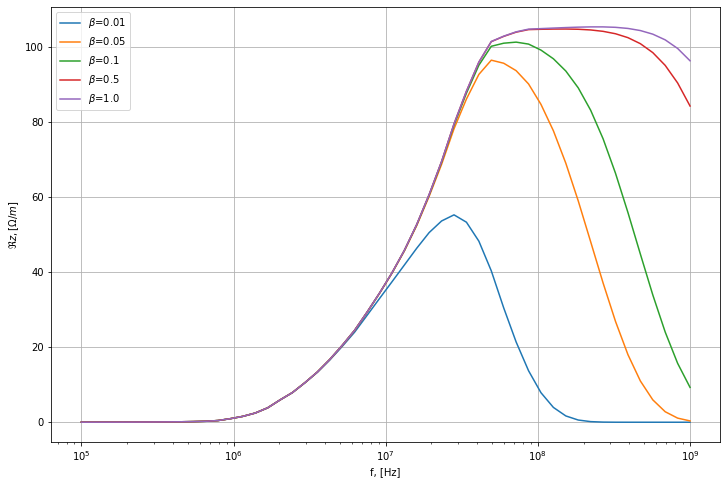

In [12]:
for d in data:
    pylab.plot(d[:,0], d[:,1]*0.0254)
pylab.xscale("log")
pylab.xlabel("f, [Hz]")
pylab.ylabel(r"$\Re{z}, [\Omega/m]$")
pylab.grid()
pylab.legend([r"$\beta$=" + f"{b}" for b in betas])
pylab.show()

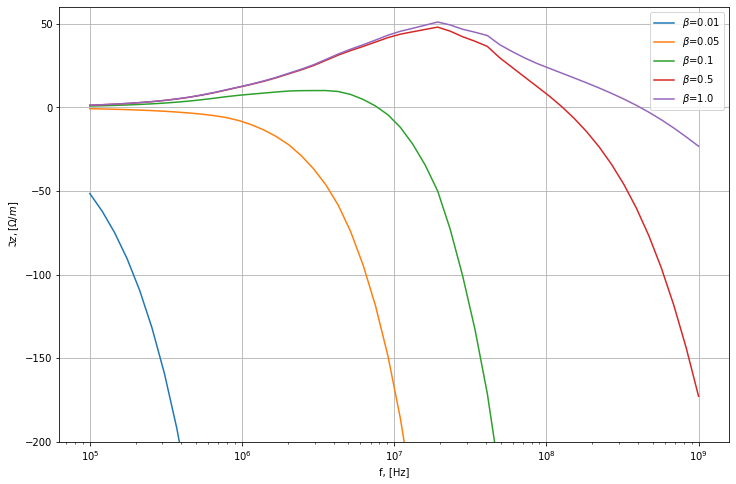

In [13]:
for d in data:
    pylab.plot(d[:,0], d[:,2]*0.0254)
pylab.xscale("log")
pylab.xlabel("f, [Hz]")
pylab.ylim((-200, 60))
pylab.ylabel(r"$\Im{z}, [\Omega/m]$")
pylab.grid()
pylab.legend([r"$\beta$=" + f"{b}" for b in betas])
pylab.show()